# <span style='color:green'>MUCH NEEDED LIBRARIES</span>

In [1]:
import shap
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder

# <span style='color:green'>Model Output Value Container</span>

In [2]:
SPECIAL_EDITION_DataFrame_of_Holding = pd.DataFrame()

# <span style='color:green'>Low income dummy variable creation</span>

In [3]:
data_li = pd.read_csv('lowIncomeFilteredData.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
# use one hot encoding to convert categorical variables into series of binary variables
non_binary_cat_vars = ['ACPRIMARY','BLD','COOKFUEL','DIVISION','HEATFUEL', 'HEATTYPE','HHRACE','HOTWATER','TENURE']
cat_df = data_li[non_binary_cat_vars].copy(deep=True)
enc = OneHotEncoder()
enc.fit(cat_df)
onehotlabels = enc.transform(cat_df).toarray()
one_hot_df = pd.DataFrame(onehotlabels, columns=enc.get_feature_names_out())
# recombine dataframes
final_data_li = pd.concat([one_hot_df,data_li.drop(columns=non_binary_cat_vars)], axis=1)
final_data_li.drop(final_data_li.loc[final_data_li['BURDEN']>1.3068144].index, inplace=True)
final_data_li.drop(final_data_li.loc[final_data_li['BURDEN']<=0].index, inplace=True)
final_data_li.drop(final_data_li.loc[final_data_li['HINCP']==0].index, inplace=True)
final_data_li.to_csv('lowIncomeFilteredData_dummy.csv')

# <span style="color: green;">READING IN DATA</span>

In [4]:
# Reading in dataset
# Specify filenames of datasets (dummy variables)
all_income = 'final_cleaned_dummy_data.csv'
low_income = 'lowIncomeFilteredData_dummy.csv'

# Non-dummy variables assigned
#all_income = 'final_cleaned_data.csv'
#low_income = 'lowIncomeFilteredData.csv'

response_var = 'BURDEN'

# Specify columns to keep
Predictors = ['ACPRIMARY_0', 'ACPRIMARY_1', 'ACPRIMARY_2', 'ACPRIMARY_3', 'ACPRIMARY_4', 'ACPRIMARY_5', 'ACPRIMARY_6', 'ACPRIMARY_7', 'BLD_1', 'BLD_2', 'BLD_3', 'BLD_4', 'BLD_5', 'BLD_6', 'BLD_7', 'BLD_8', 'BLD_9', 'COOKFUEL_0', 'COOKFUEL_1', 'COOKFUEL_2', 'COOKFUEL_3', 'COOKFUEL_4', 'DIVISION_1', 'DIVISION_2', 'DIVISION_3', 'DIVISION_4', 'DIVISION_5', 'DIVISION_6', 'DIVISION_7', 'DIVISION_8', 'DIVISION_9', 'HEATFUEL_0', 'HEATFUEL_1', 'HEATFUEL_2', 'HEATFUEL_3', 'HEATFUEL_4', 'HEATFUEL_5', 'HEATFUEL_6', 'HEATFUEL_7', 'HEATFUEL_8', 'HEATFUEL_9', 'HEATTYPE_0', 'HEATTYPE_1', 'HEATTYPE_2', 'HEATTYPE_3', 'HEATTYPE_4', 'HEATTYPE_5', 'HEATTYPE_6', 'HEATTYPE_7', 'HEATTYPE_8', 'HEATTYPE_9', 'HEATTYPE_10', 'HEATTYPE_11', 'HEATTYPE_12', 'HEATTYPE_13', 'HHRACE_1.0', 'HHRACE_2.0', 'HHRACE_3.0', 'HHRACE_4.0', 'HHRACE_5.0', 'HHRACE_6.0', 'HOTWATER_0', 'HOTWATER_1', 'HOTWATER_2', 'HOTWATER_3', 'HOTWATER_4', 'HOTWATER_5', 'HOTWATER_6', 'TENURE_0.0', 'TENURE_1.0', 'TENURE_2.0', 'FIREPLACE', 'NUMELDERS', 'NUMYNGKIDS', 'NUMOLDKIDS', 'URBAN', 'SOLAR', 'UNITSIZE', 'YRBUILT']

In [5]:
# Function to read files to dataframe
def read_to_df(filename, response, Keep_list):
    data = pd.read_csv(filename)
    y = data[response]
    
    # Dropping infinite and nan values of y and corresponding index of data
    j = 0
    for i in y:
        if i == float('inf'):
            y = y.drop([j])
            data = data.drop([j])
        elif np.isnan(i) == True:
            y = y.drop([j])
            data = data.drop([j])
        j += 1
    
    # Agnostic drop code (can drop any column as long as it contains specific word)
    for i in data:
        if i not in Keep_list:
            data = data.drop([i], axis=1)

    return y, data

In [6]:
# Creating the datasets (cleaned and filtered)

# All Income both (urban and rural)
y_all, all_income_df = read_to_df(all_income, response_var, Predictors)
                   
# Low Income both (urban and rural)
y_low, low_income_df = read_to_df(low_income, response_var, Predictors)

# <span style="color: red;">SIMPLE LINEAR REGRESSION</span>

In [7]:
# Creating model runs (6)

# Urban
def Urban_set(data, y):
    index = data.index
    j = 0
    for i in data['URBAN']:
        if i == 0:
            data = data.drop([index[j]])
            y = y.drop([index[j]])
        j += 1
    return data, y

# Rural
def Rural_set(data, y):
    index = data.index
    j = 0
    for i in data['URBAN']:
        if i == 1:
            data = data.drop([index[j]])
            y = y.drop([index[j]])
        j += 1
    return data, y

In [8]:
# All Urban
all_income_df_urban, y_all_urban = Urban_set(all_income_df, y_all)

# All Rural
all_income_df_rural, y_all_rural = Rural_set(all_income_df, y_all)

# Low Urban
low_income_df_urban, y_low_urban = Urban_set(low_income_df, y_low)

# Low Rural
low_income_df_rural, y_low_rural = Rural_set(low_income_df, y_low)

In [9]:
# Simple linear regression with best predictor
def SLR(data_train, data_val, y_train, y_val):
    
    # Find best predictor
    compare = 0
    for i in data_train.columns:
        
        data_basis_train = data_train[i]
        data_basis_train = np.array(data_basis_train).reshape(-1, 1)
        
        data_basis_val = data_val[i]
        data_basis_val = np.array(data_basis_val).reshape(-1, 1)
        
        regr = linear_model.LinearRegression().fit(data_basis_train, y_train)
        
        y_pred_val = regr.predict(data_basis_val)
        y_pred_train = regr.predict(data_basis_train)
        
        if r2_score(y_val, y_pred_val) > compare:
            y_pred_best_val = y_pred_val
            compare_val = r2_score(y_val, y_pred_val)
            predictor_best_val = i
            
        if r2_score(y_train, y_pred_train) > compare:
            y_pred_best_train = y_pred_train
            compare_train = r2_score(y_train, y_pred_train)
            predictor_best_train = i
    
    MSE_val = mse(y_val, y_pred_best_val)
    MSE_train = mse(y_train, y_pred_best_train)

    return y_pred_best_val, predictor_best_val, compare_val, MSE_val, y_pred_best_train, predictor_best_train, compare_train, MSE_train, regr

# <span style="color: blue;">Unskewed response variable [USING]</span>

In [10]:
# Unskew parameter
percentile = 97.5
def response_unskew(data, y):
    p = np.percentile(y, percentile)
    index = y.index
    j = 0
    for i in y:
        if i > p:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        elif i <= 0:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        j += 1
    return data, y

# <span style="color: blue">Convert Categorical response [NOT USING]</span>

In [11]:
def continuous_to_categorical(y):
    p1 = np.percentile(y, 20)
    p2 = np.percentile(y, 40)
    p3 = np.percentile(y, 60)
    p4 = np.percentile(y, 80)
    p5 = np.percentile(y, 100)
    PL = [p1, p2, p3, p4, p5]
    a = 0
    for i in PL:
        for j in y:
            if i >= j:
                y[y.tolist().index(j)] = a
        a+= 1
    return y

# <span style="color: blue">Shapley Plots and Figures</span>

In [12]:
def Shapley_bee_bar(model, data):
    # Computing shapley values
    explainer = shap.Explainer(model, data)
    shap_values = explainer(data)
    
    # Plotting beeswarm
    shap.plots.beeswarm(shap_values, color=plt.get_cmap('veridian'))
    plt.show()
    
    # Plotting bar
    shap.plots.bar(shap_values.abs.mean(0))
    plt.show()
    return

# <span style="color: green;">Income to Energy Burden Plot</span>

In [13]:
# Pre-analysis datasets
y_all_dirty, all_income_df_dirty = read_to_df(all_income, response_var, Predictors+['HINCP'])
ADFD_unskew, YAD_unskew = response_unskew(all_income_df_dirty, y_all_dirty)

y_low_dirty, low_income_df_dirty = read_to_df(low_income, response_var, Predictors+['HINCP'])
LDFD_unskew, YLD_unskew = response_unskew(low_income_df_dirty, y_low_dirty)

In [14]:
# Percentile Lines
PL90, PL90L = [], []
PL50, PL50L = [], []
PL25, PL25L = [], []
for i in YAD_unskew:
    PL90.append(float(np.percentile(ADFD_unskew['HINCP'],90)))
    PL50.append(float(np.percentile(ADFD_unskew['HINCP'],50)))
    PL25.append(float(np.percentile(ADFD_unskew['HINCP'],25)))
for i in YLD_unskew:
    PL90L.append(float(np.percentile(LDFD_unskew['HINCP'],90)))
    PL50L.append(float(np.percentile(LDFD_unskew['HINCP'],50)))
    PL25L.append(float(np.percentile(LDFD_unskew['HINCP'],25)))

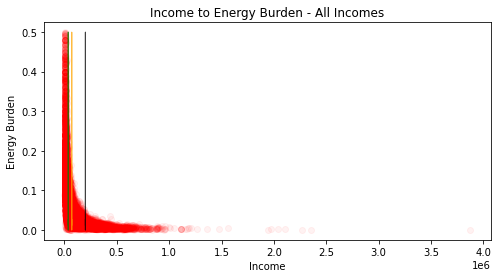

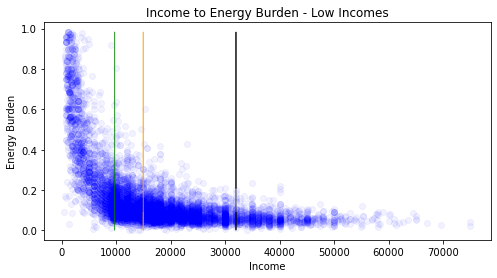

In [15]:
# Plotting
# Size All
A = plt.figure()
A.set_figwidth(8)
A.set_figheight(4)

# All Income
plt.scatter(ADFD_unskew['HINCP'], YAD_unskew, color='red', alpha=0.05)
plt.plot(PL90, YAD_unskew, linewidth=1, color='black', alpha=0.75)
plt.plot(PL50, YAD_unskew, linewidth=1, color='orange', alpha=0.75)
plt.plot(PL25, YAD_unskew, linewidth=1, color='green', alpha=0.75)
plt.title('Income to Energy Burden - All Incomes')
plt.xlabel('Income')
plt.ylabel('Energy Burden')
plt.show()

# Size Low
L = plt.figure()
L.set_figwidth(8)
L.set_figheight(4)

# Low Income
plt.scatter(LDFD_unskew['HINCP'], YLD_unskew, color='blue', alpha=0.05)
plt.plot(PL90L, YLD_unskew, linewidth=1, color='black', alpha=0.75)
plt.plot(PL50L, YLD_unskew, linewidth=1, color='orange', alpha=0.75)
plt.plot(PL25L, YLD_unskew, linewidth=1, color='green', alpha=0.75)
plt.title('Income to Energy Burden - Low Incomes')
plt.xlabel('Income')
plt.ylabel('Energy Burden')
plt.show()

# <span style="color: blue;">Train-Test Split</span>

The idea is to perform tt_split over each set of model data THEN carry the following test and validation sets through the predictor filtering processes (SLR best predictor, Lasso):
- SLR: Find predictor with lowest RSS and model with that
   - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF
- MLR: Regular MLR
    - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF
- Lasso
    - Using each model run (set of predictors), compare validation MSE and R2  with validation score and test MSE of RF

In [16]:
# Unskew data
# Convention: all_income_df (ADF), low_income_df (LDF), y_all (YA), y_low (YL)
# Convention: Urban (U), Rural (R)

# Both
ADF, YA = response_unskew(all_income_df, y_all)
LDF, YL = response_unskew(low_income_df, y_low)

# Rural
ADF_R, YA_R = response_unskew(all_income_df_rural, y_all_rural)
LDF_R, YL_R = response_unskew(low_income_df_rural, y_low_rural)

# Urban
ADF_U, YA_U = response_unskew(all_income_df_urban, y_all_urban)
LDF_U, YL_U = response_unskew(low_income_df_urban, y_low_urban)

In [17]:
def tt_split(data, response, split, random):
    X_train, X_val, y_train, y_val = train_test_split(data, response, test_size = split, random_state = random)
    return X_train, X_val, y_train, y_val

In [18]:
# Both
ADF_train, ADF_val, YA_train, YA_val = tt_split(ADF, YA, 0.2, 0)
LDF_train, LDF_val, YL_train, YL_val = tt_split(LDF, YL, 0.2, 0)

# Urban
ADF_train_U, ADF_val_U, YA_train_U, YA_val_U = tt_split(ADF_U, YA_U, 0.2, 0)
LDF_train_U, LDF_val_U, YL_train_U, YL_val_U = tt_split(LDF_U, YL_U, 0.2, 0)

# Rural
ADF_train_R, ADF_val_R, YA_train_R, YA_val_R = tt_split(ADF_R, YA_R, 0.2, 0)
LDF_train_R, LDF_val_R, YL_train_R, YL_val_R = tt_split(LDF_R, YL_R, 0.2, 0)

In [19]:
# SLR (9 Outputs)
# SLR(data_train, data_val, y_train, y_val)
# y_pred_best_val, predictor_best_val, compare_val, MSE_val, 
# y_pred_best_train, predictor_best_train, compare_train, MSE_train
# Convention: YPBV, PBV, CV, MSEV, YPBT, PBT, CT, MSET

# Both
YPBV_ADF, PBV_ADF, CV_ADF, MSEV_ADF, YPBT_ADF, PBT_ADF, CT_ADF, MSET_ADF, regr_ADF = SLR(ADF_train, ADF_val, YA_train, YA_val)

YPBV_LDF, PBV_LDF, CV_LDF, MSEV_LDF, YPBT_LDF, PBT_LDF, CT_LDF, MSET_LDF, regr_LDF = SLR(LDF_train, LDF_val, YL_train, YL_val)

# Urban
YPBV_ADF_U, PBV_ADF_U, CV_ADF_U, MSEV_ADF_U, YPBT_ADF_U, PBT_ADF_U, CT_ADF_U, MSET_ADF_U, regr_ADF_U = SLR(ADF_train_U, ADF_val_U, YA_train_U, YA_val_U)

YPBV_LDF_U, PBV_LDF_U, CV_LDF_U, MSEV_LDF_U, YPBT_LDF_U, PBT_LDF_U, CT_LDF_U, MSET_LDF_U, regr_LDF_U = SLR(LDF_train_U, LDF_val_U, YL_train_U, YL_val_U)

# Rural
YPBV_ADF_R, PBV_ADF_R, CV_ADF_R, MSEV_ADF_R, YPBT_ADF_R, PBT_ADF_R, CT_ADF_R, MSET_ADF_R, regr_ADF_R = SLR(ADF_train_R, ADF_val_R, YA_train_R, YA_val_R)

YPBV_LDF_R, PBV_LDF_R, CV_LDF_R, MSEV_LDF_R, YPBT_LDF_R, PBT_LDF_R, CT_LDF_R, MSET_LDF_R, regr_LDF_R = SLR(LDF_train_R, LDF_val_R, YL_train_R, YL_val_R)


In [20]:
def Plotter(data, pred, y, y_pred, title_):
    plt.scatter(data[pred], y, color='black', alpha = 0.25)
    plt.plot(data[pred], y_pred, color='green', linewidth=1)
    plt.title(title_)
    plt.xlabel(pred)
    plt.ylabel('Energy Burden')
    plt.show()
    return

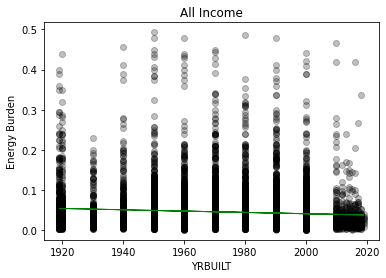

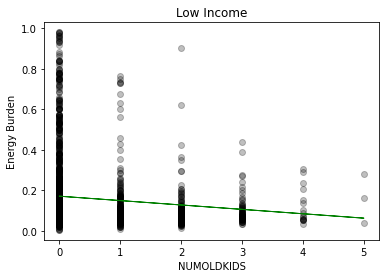

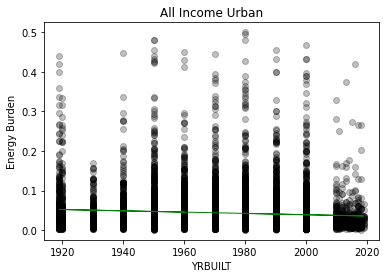

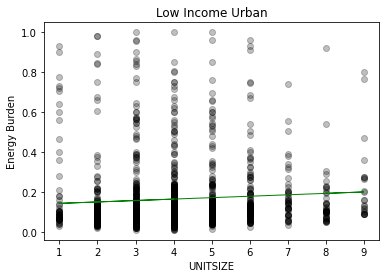

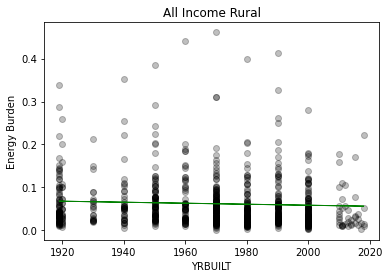

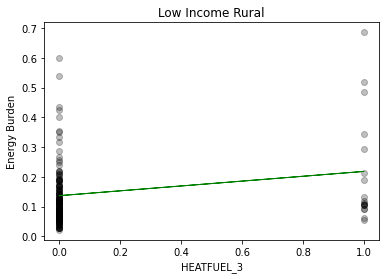

In [21]:
# Plot All Income
Plotter(ADF_val, PBV_ADF, YA_val, YPBV_ADF, 'All Income')

# Plot Low Income
Plotter(LDF_val, PBV_LDF, YL_val, YPBV_LDF, 'Low Income')

# Plot All Income Urban
Plotter(ADF_val_U, PBV_ADF_U, YA_val_U, YPBV_ADF_U, 'All Income Urban')

# Plot Low Income Urban
Plotter(LDF_val_U, PBV_LDF_U, YL_val_U, YPBV_LDF_U, 'Low Income Urban')

# Plot All Income Rural
Plotter(ADF_val_R, PBV_ADF_R, YA_val_R, YPBV_ADF_R, 'All Income Rural')

# Plot Low Income Rural
Plotter(LDF_val_R, PBV_LDF_R, YL_val_R, YPBV_LDF_R, 'Low Income Rural')

In [22]:
# Best R2 and MSE (validation set)

# All Income
print('Best R2 of SLR on all income: ', CV_ADF)
print('Validation MSE on all income: ', MSEV_ADF)
print('\n')
# Low Income
print('Best R2 of SLR on low income: ', CV_LDF)
print('Validation MSE on low income: ', MSEV_LDF)
print('\n')
# All Income Urban
print('Best R2 of SLR on all income Urban: ', CV_ADF_U)
print('Validation MSE on all income Urban: ', MSEV_ADF_U)
print('\n')
# Low Income Urban
print('Best R2 of SLR on low income Urban: ', CV_LDF_U)
print('Validation MSE on low income Urban: ', MSEV_LDF_U)
print('\n')
# All Income Rural
print('Best R2 of SLR on all income Rural: ', CV_ADF_R)
print('Validation MSE on all income Rural: ', MSEV_ADF_R)
print('\n')
# Low Income Rural
print('Best R2 of SLR on low income Rural: ', CV_LDF_R)
print('Validation MSE on low income Rural: ', MSEV_LDF_R)

Best R2 of SLR on all income:  0.007888647986280084
Validation MSE on all income:  0.0027825269806465575


Best R2 of SLR on low income:  0.020685683312327674
Validation MSE on low income:  0.03185416769922205


Best R2 of SLR on all income Urban:  0.005744436454458435
Validation MSE on all income Urban:  0.0028066438937157227


Best R2 of SLR on low income Urban:  0.0010251152230968952
Validation MSE on low income Urban:  0.03113178985500087


Best R2 of SLR on all income Rural:  0.0065722862491366385
Validation MSE on all income Rural:  0.003558538699480758


Best R2 of SLR on low income Rural:  0.043013003316344056
Validation MSE on low income Rural:  0.01018419848086748


# <span style='color:pink'>(╯°□°)╯︵ ┻━┻</span>

In [23]:
SPECIAL_EDITION_DataFrame_of_Holding['Configuration'] = ['All Income', 'Low Income', 'All Income Urban', 'Low Income Urban', 'All Income Rural', 'Low Income Rural']
SPECIAL_EDITION_DataFrame_of_Holding['SLR Val MSE'] = [MSEV_ADF, MSEV_LDF, MSEV_ADF_U, MSEV_LDF_U, MSEV_ADF_R, MSEV_LDF_R]
SPECIAL_EDITION_DataFrame_of_Holding.set_index('Configuration')
SPECIAL_EDITION_DataFrame_of_Holding['SLR R-Sqred'] = [CV_ADF,CV_LDF,CV_ADF_U,CV_LDF_U,CV_ADF_R,CV_LDF_R]
SPECIAL_EDITION_DataFrame_of_Holding

,Configuration,SLR Val MSE,SLR R-Sqred
0,All Income,0.002783,0.007889
1,Low Income,0.031854,0.020686
2,All Income Urban,0.002807,0.005744
3,Low Income Urban,0.031132,0.001025
4,All Income Rural,0.003559,0.006572
5,Low Income Rural,0.010184,0.043013


# <span style="color: red;">MULTIPLE LINEAR REGRESSION</span>

# <span style='color:blue'>Intercept Assigner</span>

In [24]:
def intercepter(data):
    data = data.assign(Intercept=1)
    return data

In [25]:
# Intercept
# All Income
ADF_trainI = intercepter(ADF_train)
ADF_valI = intercepter(ADF_val)

# Low Income
LDF_trainI = intercepter(LDF_train)
LDF_valI = intercepter(LDF_val)

# All Income Urban
ADF_trainI_U = intercepter(ADF_train_U)
ADF_valI_U = intercepter(ADF_val_U)

# Low Income Urban
LDF_trainI_U = intercepter(LDF_train_U)
LDF_valI_U = intercepter(LDF_val_U)

# All Income Rural
ADF_trainI_R = intercepter(ADF_train_R)
ADF_valI_R = intercepter(ADF_val_R)

# Low Income Rural
LDF_trainI_R = intercepter(LDF_train_R)
LDF_valI_R = intercepter(LDF_val_R)

In [58]:
def MLR(data_train, data_val, y_train, y_val):
    # Creating the model
    sm_model = sm.OLS(y_train, data_train)

    # Multiple Linear Regression
    results = sm_model.fit()
    y_pred_val = results.predict(data_val)
    y_pred_train = results.predict(data_train)

    # Summary
    data_R2 = results.rsquared
    data_sum = results.summary()
    MSE_val = rmse(y_val, y_pred_val)
    MSE_train = rmse(y_train, y_pred_train)
    
    return data_R2, data_sum, MSE_val, MSE_train, results

In [71]:
# 6 Model run MLR (5 outputs)
# All Income
ADF_data_R2, ADF_data_sum, ADF_MSE_val, ADF_MSE_train, MLR_Model_ADF = MLR(ADF_trainI, ADF_valI, YA_train, YA_val)
# Low Income
LDF_data_R2, LDF_data_sum, LDF_MSE_val, LDF_MSE_train, MLR_Model_LDF = MLR(LDF_trainI, LDF_valI, YL_train, YL_val)
# All Income Urban
ADF_data_R2_U, ADF_data_sum_U, ADF_MSE_val_U, ADF_MSE_train_U, MLR_Model_ADF_U = MLR(ADF_trainI_U, ADF_valI_U, YA_train_U, YA_val_U)
# Low Income Urban
LDF_data_R2_U, LDF_data_sum_U, LDF_MSE_val_U, LDF_MSE_train_U, MLR_Model_LDF_U = MLR(LDF_trainI_U, LDF_valI_U, YL_train_U, YL_val_U)
# All Income Rural
ADF_data_R2_R, ADF_data_sum_R, ADF_MSE_val_R, ADF_MSE_train_R, MLR_Model_ADF_R = MLR(ADF_trainI_R, ADF_valI_R, YA_train_R, YA_val_R)
# Low Income Rural
LDF_data_R2_R, LDF_data_sum_R, LDF_MSE_val_R, LDF_MSE_train_R, MLR_Model_LDF_R = MLR(LDF_trainI_R, LDF_valI_R, YL_train_R, YL_val_R)

Sum_L = [ADF_data_sum, LDF_data_sum, ADF_data_sum_U, LDF_data_sum_U, ADF_data_sum_R, LDF_data_sum_R]
Sum_N = ['ADF', 'LDF', 'ADF_U', 'LDF_U', 'ADF_R', 'LDF_R']

In [72]:
# Source: https://stackoverflow.com/questions/37289951/how-to-write-to-a-csv-line-by-line
for i in range(len(Sum_L)):
    f = open('MLR_Summary\Data_'+Sum_N[i]+'.csv','w')
    f.write(Sum_L[i].as_csv()) #Give your csv text here.
    ## Python will convert \n to os.linesep
    f.close()



# <span style='color:orange'>L(!!˚☐˚)/</span>

In [28]:
# All Income
display(ADF_data_R2)
print('ADF MSE val: ', ADF_MSE_val)
print('ADF MSE train: ', ADF_MSE_train)
# Low Income
display(LDF_data_R2)
print('ADF MSE val: ', LDF_MSE_val)
print('ADF MSE train: ', LDF_MSE_train)
# All Income Urban
display(ADF_data_R2_U)
print('ADF MSE val: ', ADF_MSE_val_U)
print('ADF MSE train: ', ADF_MSE_train_U)
# Low Income Urban
display(LDF_data_R2_U)
print('ADF MSE val: ', LDF_MSE_val_U)
print('ADF MSE train: ', LDF_MSE_train_U)
# All Income Rural
display(ADF_data_R2_R)
print('ADF MSE val: ', ADF_MSE_val_R)
print('ADF MSE train: ', ADF_MSE_train_R)
# Low Income Rural
display(LDF_data_R2_R)
print('ADF MSE val: ', LDF_MSE_val_R)
print('ADF MSE train: ', LDF_MSE_train_R)

MLR_R2_L = [ADF_data_R2,LDF_data_R2,ADF_data_R2_U,LDF_data_R2_U,ADF_data_R2_R,LDF_data_R2_R]
MLR_MSEV = [ADF_MSE_val,LDF_MSE_val,ADF_MSE_val_U,LDF_MSE_val_U,ADF_MSE_val_R,LDF_MSE_val_R]

0.08954033447999155

ADF MSE val:  0.05067991006693293
ADF MSE train:  0.052090796031269274


0.0704831089443183

ADF MSE val:  0.17659625660364503
ADF MSE train:  0.16041959018908977


0.08134609059528763

ADF MSE val:  0.050949124480654924
ADF MSE train:  0.05103165480346162


0.0722670545990639

ADF MSE val:  0.17412095423525373
ADF MSE train:  0.1708144718253516


0.09656229941298544

ADF MSE val:  0.057322137471987444
ADF MSE train:  0.05927442826702339


0.14241714548985296

ADF MSE val:  0.1062437867087195
ADF MSE train:  0.11811409030067245


In [29]:
SPECIAL_EDITION_DataFrame_of_Holding['MLR Val MSE'] = MLR_R2_L
SPECIAL_EDITION_DataFrame_of_Holding['MLR R-Sqred'] = MLR_MSEV

# <span style="color: blue;">Multicollinearity VIF Test [NOT USING]</span>

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each predictive variable, calculate VIF and save in a dataframe called "VIF"
def VIF(data):
    VIF = pd.DataFrame()
    VIF['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    VIF['Predictive Variable'] = data.columns
    VIF = VIF[VIF['Predictive Variable'] != 'Intercept']
    return VIF

# <span style="color: blue;">Re-test MLR with dropped Collinear Predictors [NOT USING]</span>

In [31]:
def collinear_drop(VIF, data):
    j = 0
    for i in VIF['VIF']:
        if i >= 10:
            data = data.drop([VIF['Predictive Variable'][j]], axis=1)
        j += 1
    return data

# <span style="color: red;">LASSO</span>

# <span style="color: blue;">Scaling Data</span>

In [32]:
def Scaler(data):
    scaler = StandardScaler()
    scaler.fit(data)
    Scale_Feature_data = scaler.transform(data)
    return Scale_Feature_data

In [33]:
# Convention: Scaler (S), Train (T), Validation (V)
# X_train, X_val, y_train, y_val
# Feature standardization and split

# All Income
ADF_S = Scaler(ADF.assign(Intercept=1))
ADF_S_T, ADF_S_V, YA_S_T, YA_S_V = tt_split(ADF_S, YA, 0.2, 0)

# Low Income
LDF_S = Scaler(LDF.assign(Intercept=1))
LDF_S_T, LDF_S_V, YL_S_T, YL_S_V = tt_split(LDF_S, YL, 0.2, 0)

# All Income Urban
ADF_S_U = Scaler(ADF_U.assign(Intercept=1))
ADF_S_T_U, ADF_S_V_U, YA_S_T_U, YA_S_V_U = tt_split(ADF_S_U, YA_U, 0.2, 0)

# Low Income Urban
LDF_S_U = Scaler(LDF_U.assign(Intercept=1))
LDF_S_T_U, LDF_S_V_U, YL_S_T_U, YL_S_V_U = tt_split(LDF_S_U, YL_U, 0.2, 0)

# All Income Rural
ADF_S_R = Scaler(ADF_R.assign(Intercept=1))
ADF_S_T_R, ADF_S_V_R, YA_S_T_R, YA_S_V_R = tt_split(ADF_S_R, YA_R, 0.2, 0)

# Low Income Rural
LDF_S_R = Scaler(LDF_R.assign(Intercept=1))
LDF_S_T_R, LDF_S_V_R, YL_S_T_R, YL_S_V_R = tt_split(LDF_S_R, YL_R, 0.2, 0)

# <span style="color: blue;">Alpha from Cross Validation</span>

In [34]:
def AlphaCV(data_train, y_train):
    Lasso_scale = LassoCV(cv=7, random_state=0).fit(data_train, y_train)
    Lasso_scale_alpha = Lasso_scale.score(data_train, y_train)
    return Lasso_scale_alpha

In [35]:
# Convention: Alpha (a)

# All Income
a_ADF = AlphaCV(ADF_S_T, YA_S_T)

# Low Income
a_LDF = AlphaCV(LDF_S_T, YL_S_T)

# All Income Urban
a_ADF_U = AlphaCV(ADF_S_T_U, YA_S_T_U)

# Low Income Urban
a_LDF_U = AlphaCV(LDF_S_T_U, YL_S_T_U)

# All Income Rural
a_ADF_R = AlphaCV(ADF_S_T_R, YA_S_T_R)

# Low Income Rural
a_LDF_R = AlphaCV(LDF_S_T_R, YL_S_T_R)

# <span style="color: blue;">Fitting Lasso Optimal Alpha</span>

In [36]:
def OptimalLasso(a, data_train, y_train, data_val, y_val):
    Lasso_optimal = Lasso(alpha = a)
    Lasso_optimal.fit(data_train, y_train)
    Lasso_optimal_mse = mse(y_val, Lasso_optimal.predict(data_val))
    return Lasso_optimal, Lasso_optimal_mse

In [37]:
# Convention: Lasso (l), optimal (o)
#alpha_test = 0.005

# All Income
lo_ADF, lo_ADF_MSE = OptimalLasso(a_ADF, ADF_S_T, YA_S_T, ADF_S_V, YA_S_V)
# Low Income
lo_LDF, lo_LDF_MSE = OptimalLasso(a_LDF, LDF_S_T, YL_S_T, LDF_S_V, YL_S_V)
# All Income Urban
lo_ADF_U, lo_ADF_MSE_U = OptimalLasso(a_ADF_U, ADF_S_T_U, YA_S_T_U, ADF_S_V_U, YA_S_V_U)
# Low Income Urban
lo_LDF_U, lo_LDF_MSE_U = OptimalLasso(a_LDF_U, LDF_S_T_U, YL_S_T_U, LDF_S_V_U, YL_S_V_U)
# All Income Rural
lo_ADF_R, lo_ADF_MSE_R = OptimalLasso(a_ADF_R, ADF_S_T_R, YA_S_T_R, ADF_S_V_R, YA_S_V_R)
# Low Income Rural
lo_LDF_R, lo_LDF_MSE_R = OptimalLasso(a_LDF_R, LDF_S_T_R, YL_S_T_R, LDF_S_V_R, YL_S_V_R)

# All Income
#lo_ADF, lo_ADF_MSE = OptimalLasso(alpha_test, ADF_S_T, YA_S_T, ADF_S_V, YA_S_V)
# Low Income
#lo_LDF, lo_LDF_MSE = OptimalLasso(alpha_test, LDF_S_T, YL_S_T, LDF_S_V, YL_S_V)
# All Income Urban
#lo_ADF_U, lo_ADF_MSE_U = OptimalLasso(alpha_test, ADF_S_T_U, YA_S_T_U, ADF_S_V_U, YA_S_V_U)
# Low Income Urban
#lo_LDF_U, lo_LDF_MSE_U = OptimalLasso(alpha_test, LDF_S_T_U, YL_S_T_U, LDF_S_V_U, YL_S_V_U)
# All Income Rural
#lo_ADF_R, lo_ADF_MSE_R = OptimalLasso(alpha_test, ADF_S_T_R, YA_S_T_R, ADF_S_V_R, YA_S_V_R)
# Low Income Rural
#lo_LDF_R, lo_LDF_MSE_R = OptimalLasso(alpha_test, LDF_S_T_R, YL_S_T_R, LDF_S_V_R, YL_S_V_R)

In [38]:
# R-squared values

ADFR2 = r2_score(YA_S_V, lo_ADF.predict(ADF_S_V))
LDFR2 = r2_score(YL_S_V, lo_LDF.predict(LDF_S_V))
ADFR2U = r2_score(YA_S_V_U, lo_ADF_U.predict(ADF_S_V_U))
LDFR2U = r2_score(YL_S_V_U, lo_LDF_U.predict(LDF_S_V_U))
ADFR2R = r2_score(YA_S_V_R, lo_ADF_R.predict(ADF_S_V_R))
LDFR2R = r2_score(YL_S_V_R, lo_LDF_R.predict(LDF_S_V_R))

LL_R2 = [ADFR2,LDFR2,ADFR2U,LDFR2U,ADFR2R,LDFR2R]

In [39]:
# All Income
print('MSEV ADF: ', lo_ADF_MSE)
# Low Income
print('MSEV LDF: ', lo_LDF_MSE)
# All Income Urban
print('MSEV ADFU: ', lo_ADF_MSE_U)
# Low Income Urban
print('MSEV LDFU: ', lo_LDF_MSE_U)
# All Income Rural
print('MSEV ADFR: ', lo_ADF_MSE_R)
# Low Income Rural
print('MSEV LDFR: ', lo_LDF_MSE_R)

lo_L = [lo_ADF_MSE,lo_LDF_MSE,lo_ADF_MSE_U,lo_LDF_MSE_U,lo_ADF_MSE_R,lo_LDF_MSE_R]

MSEV ADF:  0.0028046518961841954
MSEV LDF:  0.032604825483462885
MSEV ADFU:  0.0028238174350814138
MSEV LDFU:  0.03116378738824285
MSEV ADFR:  0.0035824801939247823
MSEV LDFR:  0.010910730955730369


In [40]:
SPECIAL_EDITION_DataFrame_of_Holding['Lasso Val MSE'] = lo_L
SPECIAL_EDITION_DataFrame_of_Holding['Lasso R-Sqred'] = LL_R2

# <span style="color: blue;">Lasso Coefficients</span>

In [41]:
def LassoCoeff(lo, data):
    lasso_coefs = pd.Series(lo.coef_, index=data.columns)
    plt.figure(figsize=(17, 5))
    plt.tick_params(axis='x', labelsize=10)
    lasso_coefs.plot(kind='bar');
    plt.show()
    return lasso_coefs

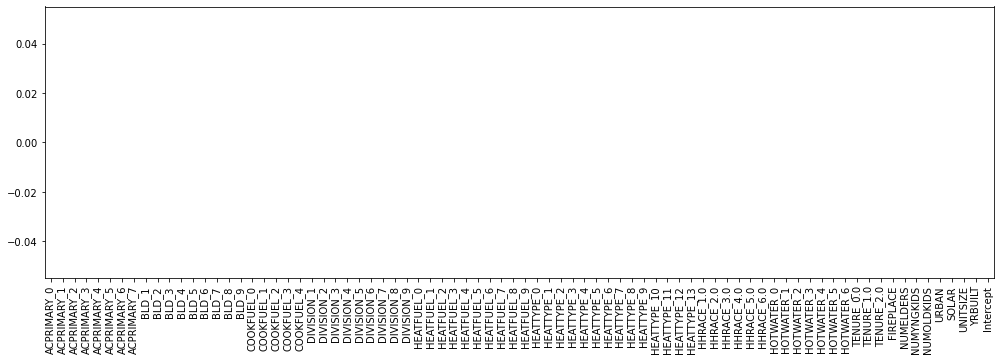

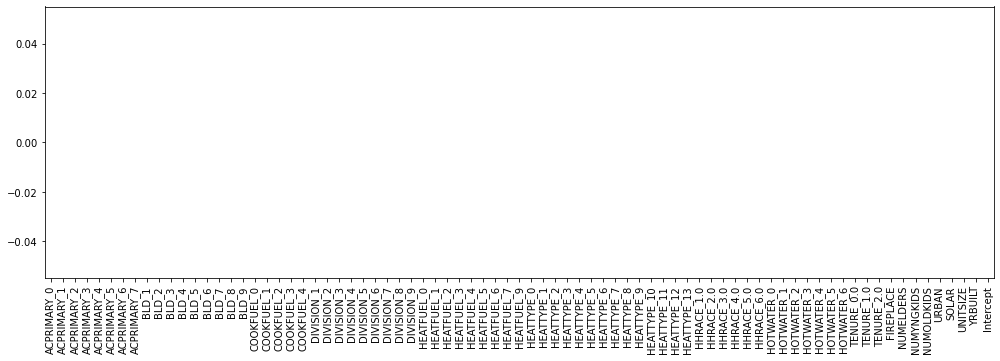

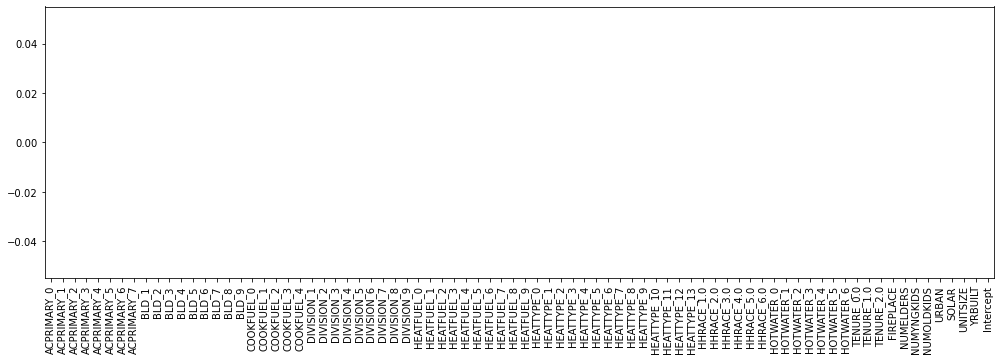

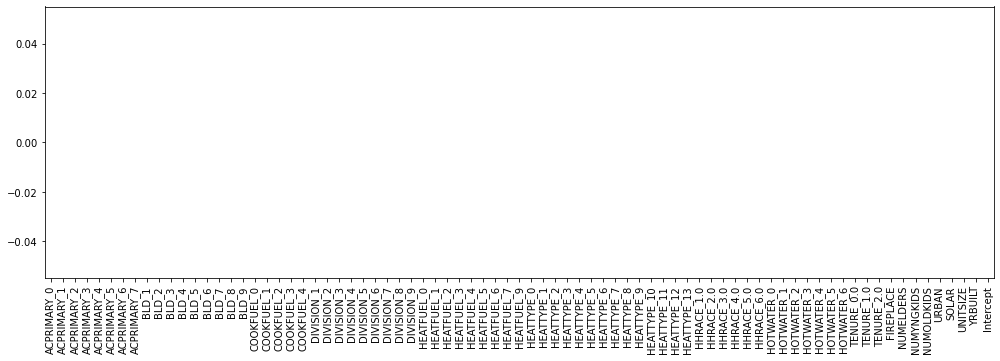

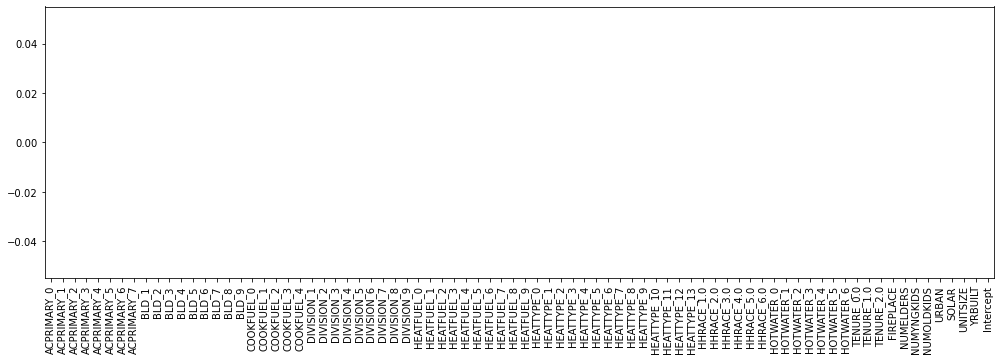

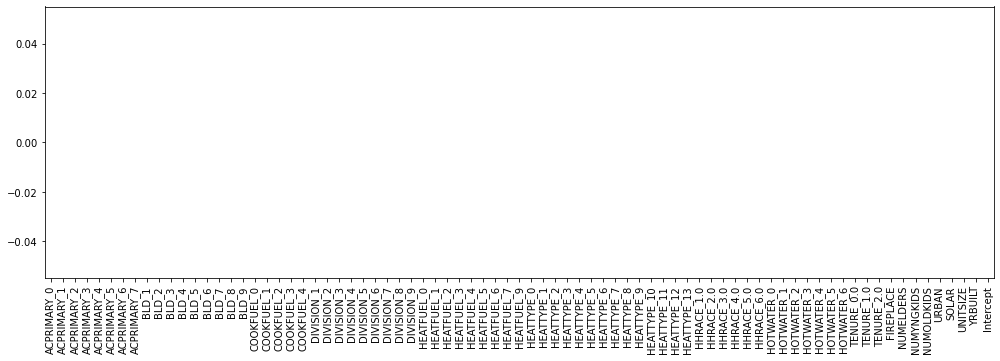

In [42]:
# Convention: lasso coefs (lc), list (L)

# All Income
lc_ADF = LassoCoeff(lo_ADF, ADF.assign(Intercept=1))

# Low Income
lc_LDF = LassoCoeff(lo_LDF, LDF.assign(Intercept=1))

# All Income Urban
lc_ADF_U = LassoCoeff(lo_ADF_U, ADF.assign(Intercept=1))

# Low Income Urban
lc_LDF_U = LassoCoeff(lo_LDF_U, LDF.assign(Intercept=1))

# All Income Rural
lc_ADF_R = LassoCoeff(lo_ADF_R, ADF.assign(Intercept=1))

# Low Income Rural
lc_LDF_R = LassoCoeff(lo_LDF_R, LDF.assign(Intercept=1))

lc_L = [lc_ADF, lc_LDF, lc_ADF_U, lc_LDF_U, lc_ADF_R, lc_LDF_R]

In [43]:
# Storing parameters in coefficient matrices (CM)
CM_ADF = pd.DataFrame([lc_L[0]])
CM_LDF = pd.DataFrame([lc_L[1]])
CM_ADF_U = pd.DataFrame([lc_L[2]])
CM_LDF_U = pd.DataFrame([lc_L[3]])
CM_ADF_R = pd.DataFrame([lc_L[4]])
CM_LDF_R = pd.DataFrame([lc_L[5]])
CM_L = [CM_ADF, CM_LDF, CM_ADF_U, CM_LDF_U, CM_ADF_R, CM_LDF_R]
CM_L_string = ['CM_ADF', 'CM_LDF', 'CM_ADF_U', 'CM_LDF_U', 'CM_ADF_R', 'CM_LDF_R']

# <span style='color:blue'>Non-zero predictors and ranking</span>

In [44]:
def imp_pred(data_list, data_list_string):
    imp = []
    a = 0
    for i in data_list:
        for j in i:
            for k in i[j]:
                if k > 0 or k < 0:
                    imp.append([j, k, data_list_string[a]])
        a += 1
    return imp

In [45]:
CM_imp = imp_pred(CM_L, CM_L_string)

In [46]:
pd.DataFrame(CM_imp, columns=['Feature', 'Importance', 'Dataset']).sort_values(by=['Importance'], ascending=False)

,Feature,Importance,Dataset


# <span style='color:green'>Publish the Book</span>

In [47]:
display(SPECIAL_EDITION_DataFrame_of_Holding)

,Configuration,SLR Val MSE,SLR R-Sqred,MLR Val MSE,MLR R-Sqred,Lasso Val MSE,Lasso R-Sqred
0,All Income,0.002783,0.007889,0.089540,0.050680,0.002805,-1.439191e-09
1,Low Income,0.031854,0.020686,0.070483,0.176596,0.032605,-2.392299e-03
2,All Income Urban,0.002807,0.005744,0.081346,0.050949,0.002824,-3.393026e-04
3,Low Income Urban,0.031132,0.001025,0.072267,0.174121,0.031164,-1.640136e-06
4,All Income Rural,0.003559,0.006572,0.096562,0.057322,0.003582,-1.113966e-04
5,Low Income Rural,0.010184,0.043013,0.142417,0.106244,0.010911,-2.525767e-02


In [48]:
SPECIAL_EDITION_DataFrame_of_Holding.to_csv('Model Summary Values.csv')

# <span style='color:black'>(｡◕‿◕｡)</span>

# Some Stuff

In [230]:
Summary_MLR_Table = pd.read_csv('MLR_Summary\Summary_Table.csv')
Summary_MLR_Table = Summary_MLR_Table.drop(['Feature.1','Feature.2','Feature.3','Feature.4','Feature.5'], axis=1)
Summary_MLR_Table = Summary_MLR_Table.set_index('Feature')

for i in Summary_MLR_Table:
    k = 0
    for j in Summary_MLR_Table[i]:
        if float(j) > 0.05:
            Summary_MLR_Table[i][Summary_MLR_Table.index[k]] = 1
        elif j == float('nan'):
            Summary_MLR_Table[i][Summary_MLR_Table.index[k]] = 0
        else:
            Summary_MLR_Table[i][Summary_MLR_Table.index[k]] = 0
        k += 1

Accumulator = []
for i in Summary_MLR_Table.index:
    Accumulator.append(Summary_MLR_Table['P>|t| '][i]+Summary_MLR_Table['P>|t| .1'][i]+Summary_MLR_Table['P>|t| .2'][i]+Summary_MLR_Table['P>|t| .3'][i]+Summary_MLR_Table['P>|t| .4'][i]+Summary_MLR_Table['P>|t| .5'][i])

Summary_MLR_Table.columns = ['ADF','LDF','ADF_U','LDF_U','ADF_R','LDF_R']
Summary_MLR_Table['Significant # Times'] = Accumulator
Summary_MLR_Table = Summary_MLR_Table.sort_values(by='Significant # Times', ascending=False)

Accumulator_2 = []
for i in Summary_MLR_Table.index:
    Accumulator_2.append(i.split('_')[0])
Aggregate = pd.DataFrame(index=np.unique(np.array(Accumulator_2)))

for i in Summary_MLR_Table.index:
    if i.split('_')[0] in Aggregate.index.tolist():
        Aggregate = Aggregate.drop([i.split('_')[0]])
    else:
        Summary_MLR_Table = Summary_MLR_Table.drop([i])

Dis_Iffier = Summary_MLR_Table.index.tolist()
j = 0
for i in Dis_Iffier:
    Dis_Iffier[j] = i.split('_')[0]
    j += 1
    
Summary_MLR_Table.index = Dis_Iffier
Summary_MLR_Table.to_csv('MLR Significant Features.csv')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
